In [30]:
import pandas as pd

# 예시 CSV 파일 불러오기 (또는 DataFrame 생성)
df1 = pd.read_csv("/content/unsmile_train_v1.0.tsv", sep='\t')  # 또는 df = pd.DataFrame(...)
df2 = pd.read_csv("/content/unsmile_valid_v1.0.tsv", sep='\t')  # 또는 df = pd.DataFrame(...)

# 각 레이블별 예측 개수 (열의 합계)
label_column1 = df1.columns[1:]
label_counts1 = df1[label_column1].sum()
label_column2 = df2.columns[1:]
label_counts2 = df2[label_column1].sum()

# 보기 좋게 출력
print("=== 각 레이블별 예측된 개수 1===")
for label, count in label_counts1.items():
    print(f"{label}: {int(count)}")


print("=== 각 레이블별 예측된 개수 2===")
for label, count in label_counts2.items():
    print(f"{label}: {int(count)}")


=== 각 레이블별 예측된 개수 1===
여성/가족: 1599
남성: 1347
성소수자: 1141
인종/국적: 1728
연령: 603
지역: 1052
종교: 1181
기타 혐오: 569
악플/욕설: 3143
clean: 3739
개인지칭: 315
=== 각 레이블별 예측된 개수 2===
여성/가족: 394
남성: 334
성소수자: 280
인종/국적: 426
연령: 146
지역: 260
종교: 290
기타 혐오: 134
악플/욕설: 786
clean: 935
개인지칭: 74


In [ ]:
https://github.com/daanVeer/HateSpeech_dataset
https://github.com/smilegate-ai/korean_unsmile_dataset?fbclid=lwAROxTIHYCWKOLtrghSL1bPm2su69-
# 한국어 데이터셋

https://gist.github.com/spikeekips/40eea22ef4a89f629abd87eed535ac6a
# 불용어 데이터셋

In [1]:
# 데이터 전처리
import pandas as pd
import re

# 전처리 대상 데이터 및 불용어 데이터 셋 불러오기
input_path = '/content/drive/MyDrive/toxic_comment_project/datasets/unsmile_train_v1.0.tsv'
stopwords_path = '/content/drive/MyDrive/toxic_comment_project/datasets/stopwords.txt'
df = pd.read_csv(input_path, sep='\t')

# 결측값 처리
df.dropna(subset=['문장'], inplace=True)

# 불용어: 한국어 데이터셋을 학습하는데에 있어 의미없는 단어 및 문장
with open(stopwords_path, 'r', encoding='utf-8') as f:
  stopwords = set(line.strip() for line in f if line.strip())

# 전처리 함수 정의
def clean_text(text):
  text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9\s]', '', text) # 특수문자를 제외한 언어만 추출
  text = re.sub(r'\s+', ' ', text).strip() # 중복 공백 삭제
  return text

# 전체 문장 전처리 적용하기 - 기존의 데이터 셋에 clean_text를 이어 붙이는 형식
df['clean_text'] = df['문장'].apply(clean_text)

# 전처리 결과만 추출 및 TSV 형식으로 저장
clean_df = df[['clean_text']]
clean_text_path = '/content/drive/MyDrive/toxic_comment_project/datasets/unsmile_clean_text.tsv'
clean_df.to_csv(clean_text_path, sep = '\n', index = False, header = False)


# 레이블 정보만 추출
label_columns = ['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타혐오', '악플/욕설', 'clean', '개인지칭']
label_df = df[label_columns]


# 레이블 정보 추출한 것을 별도의 파일로 저장
label_save_path = '/content/drive/MyDrive/toxic_comment_project/datasets/unsmile_labels.tsv'
label_df.to_csv(label_save_path, sep='\t', index=False)


In [2]:
# 데이터 셋을 1. 훈련 데이터셋, 2. 검증 데이터셋, 3. 평가 데이터셋으로 분할하기
# input: unsmile_clean_text.tsv
# output: 레이블(다중 클래스)

from sklearn.model_selection import train_test_split

# 전처리된 텍스트 불러오기 (clean_text)
clean_text_path = "/content/drive/MyDrive/toxic_comment_project/datasets/unsmile_clean_text.tsv"
X = pd.read_csv(clean_text_path, header=None)[0].tolist() # series -> list 변환

# 전처리된 레이블 불러오기
label_path = "/content/drive/MyDrive/toxic_comment_project/datasets/unsmile_labels.tsv"
Y = pd.read_csv(label_path, sep='\t').values


# 데이터셋 분할 -> random_state는 데이터를 섞는 과정에서 seed 값
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
# 전처리된 데이터셋을 훈련 데이터 셋과 나머지 데이터 셋으로 8:2 분할
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
# 나머지 데이터셋을 검증 데이터 셋과 평가 데이터셋으로 1:1 분할

# 모델 선택
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = "klue/bert-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_columns),
    problem_type="multi_label_classification"
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# 훈련 데이터 셋 및 검증 데이터 셋 토큰화 및 입력 포맷 변환하기
from transformers import AutoTokenizer

X_train = [str(x) for x in X_train]
X_valid = [str(x) for x in X_valid]

train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length = 128)
valid_encodings = tokenizer(X_valid, truncation=True, padding=True, max_length = 128)

In [4]:
# 데이터셋 객체 생성하기

import torch
# encoding: clean_text를 토근화한 것을 숫자 ID로 변환한 것
# labels: 전처리한 label_columns

class ToxicDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels=None):
    self.encodings = encodings
    if labels is not None:
      self.labels = torch.tensor(np.array(labels, dtype=np.float32))
    else:
      self.labels = None

  def __getitem__(self, idx):
    item = {
        'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
        'attention_mask': torch.tensor(self.encodings['attention_mask'][idx])
    }
    if self.labels is not None:
      item['labels'] = self.labels[idx]
    return item

  def __len__(self):
    return len(self.encodings['input_ids'])




In [78]:
import torch

# GPU 사용 가능하면 사용, 아니면 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("사용 중인 디바이스:", device)

사용 중인 디바이스: cuda


In [79]:
# 1. training argument -> 학습하는데 필요한 정보, 인자 설정하기(모델 저장 디렉토리, 학습 에포크 수, 배치 크기 등 설정)
# 2. Trainer 객체 생성(모델, 데이터셋, 평가함수(정의하기), 토크나이저 등을 trainer에게 넘겨준다)
# 3. 학습 실행(Trainer를 train() 시키기)

from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report
# f1_score는 평가함수

# 평가함수 정의(멀티 라벨이기때문에 임계값 0.5 이상이면 1로 판단)
def compute_metrics(pred):
  logits, labels = pred
  if isinstance(logits, tuple):
    logits = logits[0]
  preds = (logits > 0.5).astype(int)
  macro_f1 = f1_score(labels, preds, average="macro")
  accuracy = accuracy_score(labels, preds)
  return {
      "macro_f1": macro_f1,
      'accuracy': accuracy}

# 훈련 파라미터 설정
training_args = TrainingArguments(
    output_dir = "/content/drive/MyDrive/toxic_comment_project/outputs",
    num_train_epochs = 7,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    learning_rate=1e-5,
    weight_decay=0.05,
    warmup_ratio=0.05,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='/content/drive/MyDrive/toxic_comment_project/logs',
    logging_steps=50,
    load_best_model_at_end=True, # validation loss을 기준으로 최적의 모델 선택
    metric_for_best_model='macro_f1',
)

# Trainer 객체 생성
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = ToxicDataset(train_encodings, Y_train),
    eval_dataset = ToxicDataset(valid_encodings, Y_valid),
    compute_metrics = compute_metrics,
    tokenizer = tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.002)]
)

# 실제로 훈련 시키기
trainer.train()

# trainer.model 로 저장됨

/tmp/ipython-input-79-2359894255.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
1,0.170800,0.172523,0.549734,0.458378
2,0.143100,0.142203,0.617509,0.591249
3,0.115400,0.139803,0.649734,0.614194
4,0.096900,0.138655,0.674183,0.630203


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
1,0.170800,0.172523,0.549734,0.458378
2,0.143100,0.142203,0.617509,0.591249
3,0.115400,0.139803,0.649734,0.614194
4,0.096900,0.138655,0.674183,0.630203
5,0.075200,0.143980,0.684165,0.645144
6,0.073700,0.148417,0.703930,0.655816
7,0.071300,0.151978,0.696566,0.651547


TrainOutput(global_step=6566, training_loss=0.12244943386165609, metrics={'train_runtime': 2153.493, 'train_samples_per_second': 48.735, 'train_steps_per_second': 3.049, 'total_flos': 5555562453135618.0, 'train_loss': 0.12244943386165609, 'epoch': 7.0})

In [80]:
# WANDB aa6a65e18b7da3df184ba0a353ef2bfecde0ea33

# 나중에 재사용할 수 있도록 학습된 모델을 저장한다.
trainer.save_model("/content/drive/MyDrive/toxic_comment_project/models")
tokenizer.save_pretrained("/content/drive/MyDrive/toxic_comment_project/models")

# 다시 불러오는 방법
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/toxic_comment_project/models")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/toxic_comment_project/models")

# trainer.model 로 저장됨



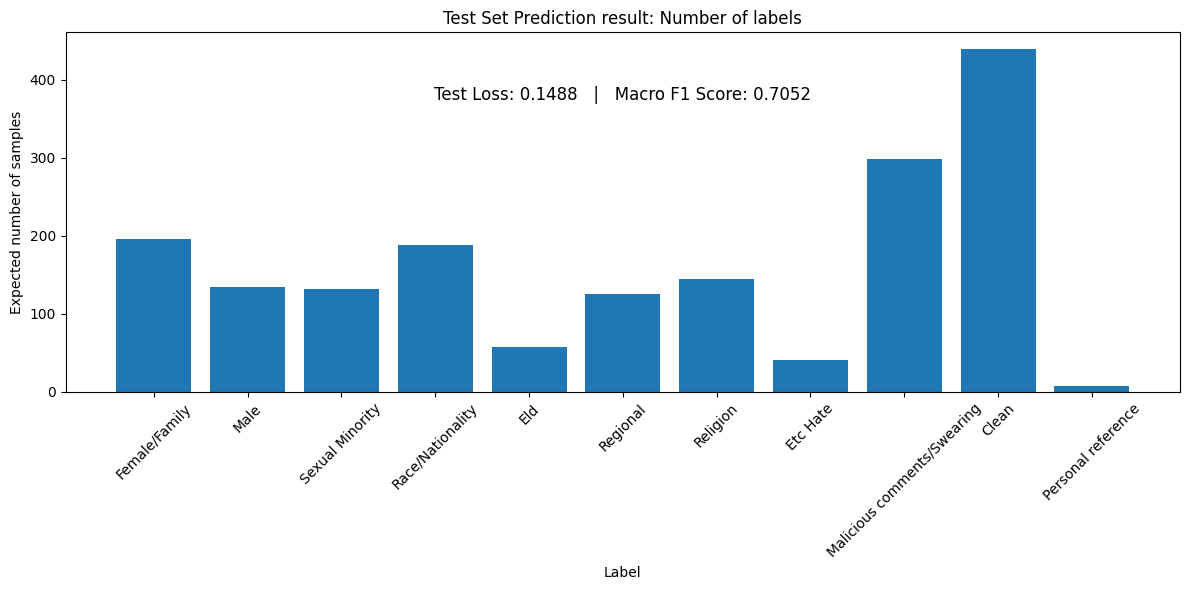

In [81]:
# 데이터 시각화



# 테스트 데이터셋 로딩
X_test = [str(x) for x in X_test] # None 방지
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)
test_dataset = ToxicDataset(test_encodings, Y_test)

# 예측(임계값 0.5 기준으로 예측)
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
preds = (logits > 0.5).astype(int)

overall_loss = predictions.metrics['test_loss']
overall_f1 = predictions.metrics['test_macro_f1']


# 레이블별 예측 개수 세기 및 시각화
import numpy as np
import matplotlib.pyplot as plt

label_names = ['Female/Family', 'Male', 'Sexual Minority', 'Race/Nationality', 'Eld', 'Regional', 'Religion', 'Etc Hate', 'Malicious comments/Swearing', 'Clean', 'Personal reference']
# 레이블이 한국어기 때문에 영어로 바꿔서 입력
# ['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'Clean여부', '개인지칭']
label_counts = np.sum(preds, axis=0) # 각 레이블이 True로 예측된 횟수를 계산

# 시각화
plt.figure(figsize=(12, 6))
plt.bar(label_names, label_counts)
plt.xticks(rotation=45)
plt.title("Test Set Prediction result: Number of labels")
plt.text(0.5, 0.8, f"Test Loss: {overall_loss:.4f}   |   Macro F1 Score: {overall_f1:.4f}",
         fontsize=12, ha='center', va='bottom', transform=plt.gca().transAxes)
plt.xlabel("Label")
plt.ylabel("Expected number of samples")
plt.tight_layout()
plt.show()

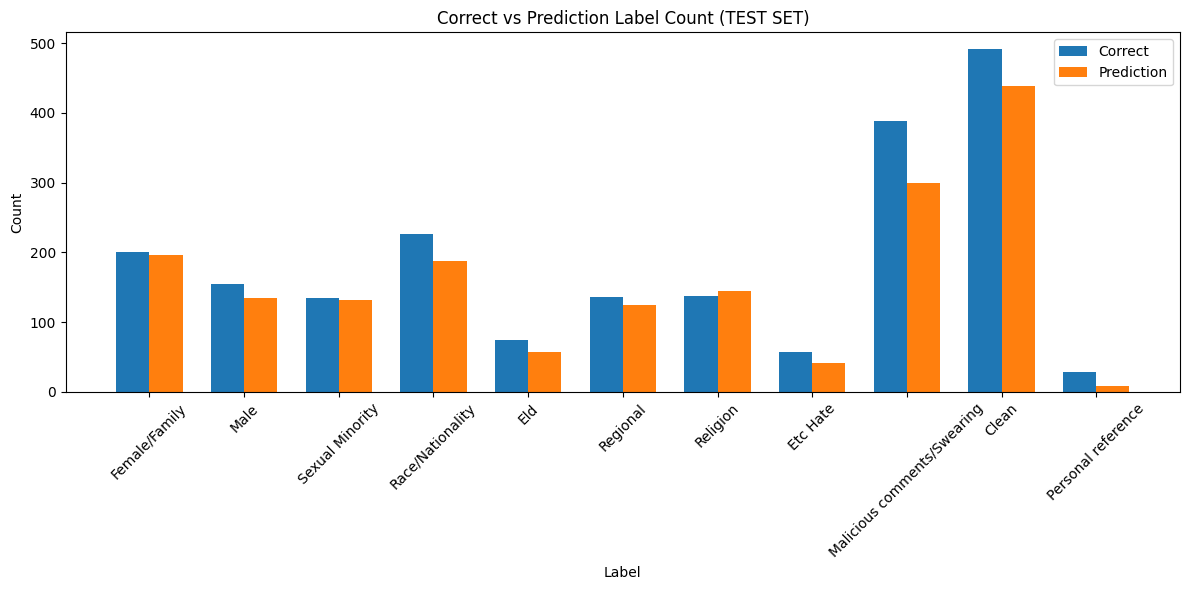

In [82]:
# 정답(Y_test)와 비교해서 정답 분포 시각화 Y_test.sum(axis=0)으로 가능
# 한 그래프에 예측 vs 정답을 함께 그린다.
label_true_counts = np.sum(Y_test, axis=0)
label_pred_counts = np.sum(preds, axis=0)

x = np.arange(len(label_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, label_true_counts, width, label='Correct')
plt.bar(x + width/2, label_pred_counts, width, label='Prediction')
plt.xticks(x, label_names, rotation=45)
plt.title("Correct vs Prediction Label Count (TEST SET)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

                             precision    recall  f1-score   support

              Female/Family       0.76      0.74      0.75       200
                       Male       0.86      0.74      0.80       155
            Sexual Minority       0.87      0.85      0.86       135
           Race/Nationality       0.85      0.71      0.77       226
                        Eld       0.91      0.69      0.79        75
                   Regional       0.91      0.84      0.87       136
                   Religion       0.84      0.88      0.86       138
                   Etc Hate       0.59      0.42      0.49        57
Malicious comments/Swearing       0.67      0.52      0.58       388
                      Clean       0.74      0.66      0.70       491
         Personal reference       0.62      0.18      0.28        28

                  micro avg       0.78      0.68      0.73      2029
                  macro avg       0.78      0.66      0.71      2029
               weighted avg     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

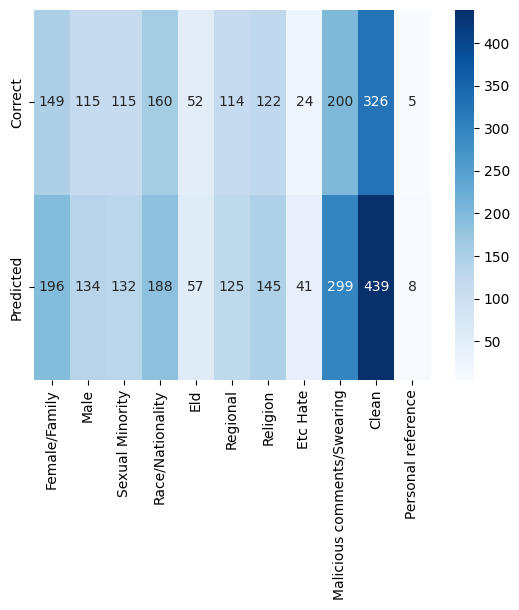

In [83]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, preds, target_names=label_names))

import seaborn as sns

correct_counts = np.sum((Y_test == 1) & (preds == 1), axis=0)
pred_counts = np.sum(preds == 1, axis=0)

compare_df = pd.DataFrame({'Correct': correct_counts, 'Predicted': pred_counts}, index=label_names)
sns.heatmap(compare_df.T, annot=True, fmt="d", cmap="Blues")

In [95]:
# 크롤링

import requests
import json
import re

def get_object_id(article_url):
  match = re.search(r'article/(\d+)/(\d+)', article_url)
  if match:
    return f"news{match.group(1)},{match.group(2)}"
  return None

def get_comments(object_id, page=1, page_size=20, sort='FAVORITE'):
  url = "https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json"
  header = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36',
    'Referer': article_url,
  }
  params = {
      'ticket': 'news',
      'templateId': 'view_economy',
      'pool': 'cbox5',
      'lang': 'ko',
      'country': 'KR',
      'objectId': object_id,
      'page': page,
      'pageSize': page_size,
      'sort': sort,
      'useAltSort': 'true',
      'replyPageSize': 20,
      'initialize': 'true',
      '_callback': 'callback',
  }

  response = requests.get(url, params=params, headers)

    # JSONP 형식 제거
  try:
      json_str = re.search(r'\((.*?)\)$', response.text, re.S).group(1)
      data = json.loads(json_str)
      comments = data['result']['commentList']
      return [c['contents'] for c in comments]
  except Exception as e:
      print("Error:", e)
      return []

comments = []

article_url = "https://n.news.naver.com/article/277/0005609764?ntype=RANKING"
object_id = get_object_id(article_url)

for page in range(1, 6):
  comments.extend(get_comments(object_id, page=page))

print(object_id)
print(comments)

# 뉴스 기사는 크롤링이 막아져있어, 실제 뉴스 기사의 댓글을 크롤링하는 것은 쉽지 않았음.
# 또 다른 악성 댓글 데이터 셋을 사용해서 모델에 적용
# 또한 직접 몇 가지 데이터를 크롤링 해와 결과를 실험하였음.

Error: 'NoneType' object has no attribute 'group'
Error: 'NoneType' object has no attribute 'group'
Error: 'NoneType' object has no attribute 'group'
Error: 'NoneType' object has no attribute 'group'
Error: 'NoneType' object has no attribute 'group'
news277,0005609764
[]


In [17]:
import pandas as pd
from transformers import TrainingArguments, Trainer

df = pd.read_csv("/content/drive/MyDrive/toxic_comment_project/datasets/Dataset.tsv", sep='\t')
df['content'].to_csv("new_inputs.tsv", index=False, header=False, encoding="utf-8-sig")

# 문장만 추출해서 파일에 따로 저장하기

with open("new_inputs.tsv", encoding="utf-8-sig") as f:
  new_texts = [line.strip() for line in f.readlines() if line.strip()]

experiment_encodings = tokenizer(new_texts, truncation=True, padding=True, max_length=128)
experiment_dataset = ToxicDataset(experiment_encodings)

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/toxic_comment_project/models")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/toxic_comment_project/models")

training_args = TrainingArguments(
    output_dir = "/content/drive/MyDrive/toxic_comment_project/outputs",
    per_device_eval_batch_size = 16,
)

trainer = Trainer(
    model = model,
    args = training_args,
    tokenizer = tokenizer
)


predictions = trainer.predict(experiment_dataset)
logits = predictions.predictions
probs = torch.sigmoid(torch.tensor(logits)).numpy()
preds = (probs >= 0.5).astype(int)

label_names = ['여성/가족', '남성', '성소수자','인종/국적', '연령', '지역', '종교', '기타혐오', '악플/욕설', 'clean', '개인지칭']

result_rows = []
for text, pred in zip(new_texts, preds):
  predicted = [label_names[i] for i, val in enumerate(pred) if val == 1]
  result_rows.append({
      "content": text,
      "predicted_labels": ", ".join(predicted) if predicted else "None"
  })

result_df = pd.DataFrame(result_rows)
result_df.to_csv("predicted_results.csv", index=False, encoding="utf-8-sig")

/tmp/ipython-input-17-4256476481.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sbosung0610 (sbosung0610-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


=== 예측된 레이블별 개수 ===
Female/Family (여성/가족): 652
Male         (남성): 128
Sexual Minority (성소수자): 42
Race/Nationality (인종/국적): 382
Eld          (연령): 136
Regional     (지역): 132
Religion     (종교): 59
Etc Hate     (기타혐오): 319
Malicious comments/Swearing (악플/욕설): 3084
Clean        (clean): 4655
Personal reference (개인지칭): 274





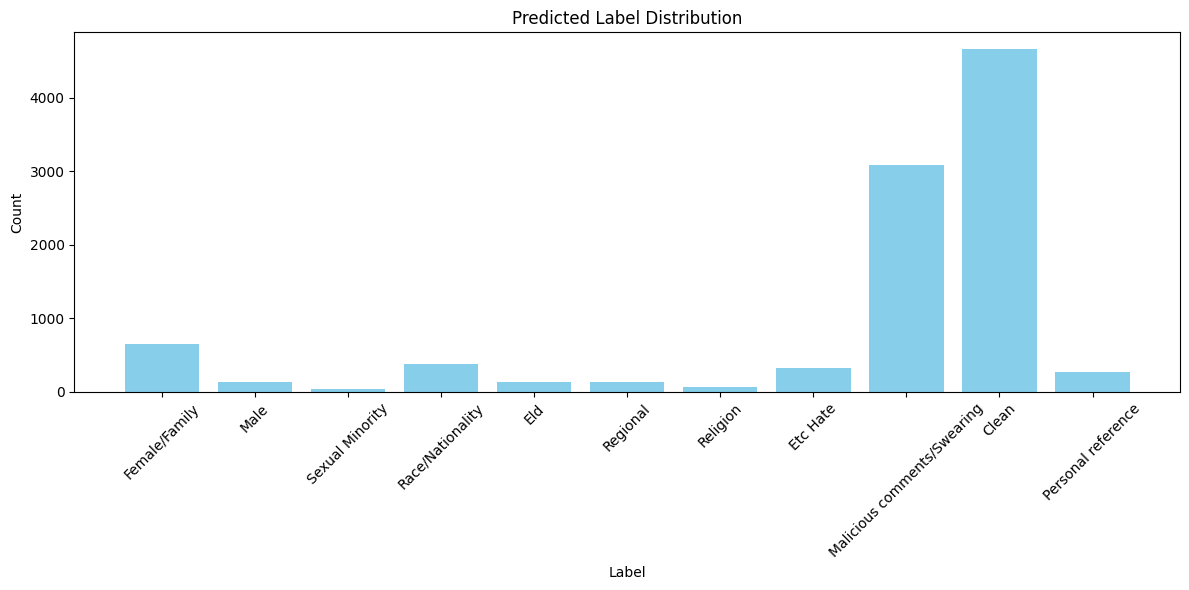

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# 예측 결과 CSV 불러오기
df = pd.read_csv("/content/drive/MyDrive/toxic_comment_project/datasets/predicted_results.tsv", encoding="utf-8-sig")

# 'predicted_labels' 컬럼에서 모든 예측된 레이블을 분리
all_labels = []
for labels in df['predicted_labels']:
    if isinstance(labels, str) and labels.lower() != "none":
        all_labels.extend([label.strip() for label in labels.split(',')])

# 레이블별 예측 수 세기
label_counts = Counter(all_labels)

# 레이블 리스트 고정 순서로 만들기 (원래 있던 label_names 기준)
label_names = ['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타혐오', '악플/욕설', 'clean', '개인지칭']

label_names_en =  ['Female/Family', 'Male', 'Sexual Minority', 'Race/Nationality', 'Eld', 'Regional', 'Religion', 'Etc Hate', 'Malicious comments/Swearing', 'Clean', 'Personal reference']

counts = [label_counts.get(label, 0) for label in label_names]

print("=== 예측된 레이블별 개수 ===")
for ko, en in zip(label_names, label_names_en):
    count = label_counts.get(ko, 0)
    print(f"{en:12} ({ko}): {count}")

print("\n\n")

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(label_names_en, counts, color='skyblue')
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Predicted Label Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 분류된 악성 댓글: 5208
# 분류된 악성X: 4655
# None 으로 분류된것: 137

In [87]:
# 모델 예측 및 저장
import torch
from transformers import AutoTokenizer
from torch.utils.data import Dataset

# 1. 토크나이징

encodings = tokenizer(comments, truncation=True, padding=True, max_length=128)

# 2. 데이터 셋 만들기

inference_dataset = ToxicDataset(encodings, label=None)

# 3. 예측
predictions = trainer.predict(inference_dataset)
logits = predictions.predictions
preds = (logits > 0.5).astype(int)

# 결과 저장
import pandas as pd

results_df = pd.DataFrame(preds, columns=label_columns) # 예측 결과 삽입
results_df.insert(0, 'comment', comments) # 첫번째 열에 comment 삽입

results_df.to_csv("predicted_comments.csv", index=False)

# 예측 결과 시각화
import matplotlib.pyplot as plt

# 예측된 라벨별 개수
label_counts = results_df[label_columns].sum()

plt.figure(figsize=(10,6))
plt.bar(label_columns, label_counts)
plt.xticks(rotation=45)
plt.ylabel("Predicted number of comments")
plt.title("Comment classification results(Multi Label)")
plt.tight_layout()
plt.show()

"""
for i, comment in enumerate(comments):
    predicted_labels = [label_names[j] for j, val in enumerate(preds[i]) if val == 1]
    print(f"\n🗨️ 댓글: {comment}")
    print(f"📌 예측 레이블: {predicted_labels}")
"""

IndexError: list index out of range

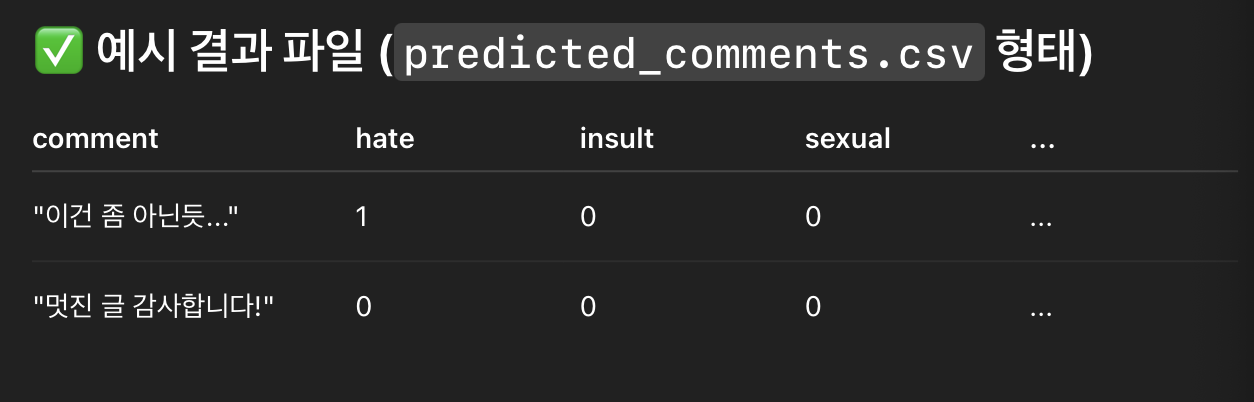

In [ ]:
https://n.news.naver.com/article/comment/014/0005365219
https://n.news.naver.com/article/023/0003911952?ntype=RANKING
https://n.news.naver.com/article/087/0001123932?ntype=RANKING
https://n.news.naver.com/article/087/0001124053?ntype=RANKING
https://n.news.naver.com/article/277/0005609764?ntype=RANKING

In [ ]:
https://www.inews24.com/view/1444614 # 데이터셋 정보
https://github.com/ZIZUN/korean-malicious-comments-dataset/blob/master/Dataset.csv
# 예측 데이터 셋
https://github.com/kocohub/korean-hate-speech
# 참고 자료